In [147]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from datetime import datetime
from dateutil.relativedelta import relativedelta

emphasize = 'Rocky Linux'
figx = 16.18
figy = 10
plotstyle = 'ggplot'
startdate = datetime.now() - relativedelta(years=1)
startdatelong = '2020-12-08'
archivedir = 'archive/'
datadir = 'data/'
workdir = 'out/'

def thousands(x, pos):
    return '{:,.0f}k'.format(x*1e-3)

def millions(x, pos):
    return '{:,.1f}M'.format(x*1e-6)

distros = ['AlmaLinux', 'CentOS Stream', 'Oracle Linux Server', 'Red Hat Enterprise Linux', 'Rocky Linux']
colors = {'AlmaLinux':'#4AC1FA', 'CentOS Linux':'#E9A942', 'CentOS Stream':'#9A5689', 'Oracle Linux Server':'#BE503B', 'Red Hat Enterprise Linux':'#E2321D', 'Rocky Linux':'#48B585'}
labels = {'AlmaLinux':'AlmaLinux', 'CentOS Linux':'CentOS Legacy', 'CentOS Stream':'CentOS Stream', 'Oracle Linux Server':'Oracle', 'Red Hat Enterprise Linux':'RHEL', 'Rocky Linux':'Rocky Linux'}

In [155]:
# Data import and preprocessing

epel_dataframe = pd.read_csv(archivedir + '2023-04-13/epel.csv')

# Drop data covered by new data
epel_dataframe = epel_dataframe.drop(epel_dataframe[epel_dataframe['week_end'] > '2023-01-01'].index)

# Concatenate new data
epel_dataframe = pd.concat([epel_dataframe, pd.read_csv(datadir + 'epel.csv')])

epel_dataframe['week_end'] = pd.to_datetime(epel_dataframe['week_end'])
epel_dataframe['week_start'] = pd.to_datetime(epel_dataframe['week_start'])

# Data errors:

# There's a very obvious misconfiguration or manipulation in the data, where
# almost half a million RHEL boxes appear out of nowhere for one week.
# epel_dataframe = epel_dataframe.drop(index=462163)

# Everything drops to almost zero for some reason on this date
# epel_dataframe = epel_dataframe.drop(epel_dataframe[epel_dataframe['week_end'] == '2023-3-26'].index)

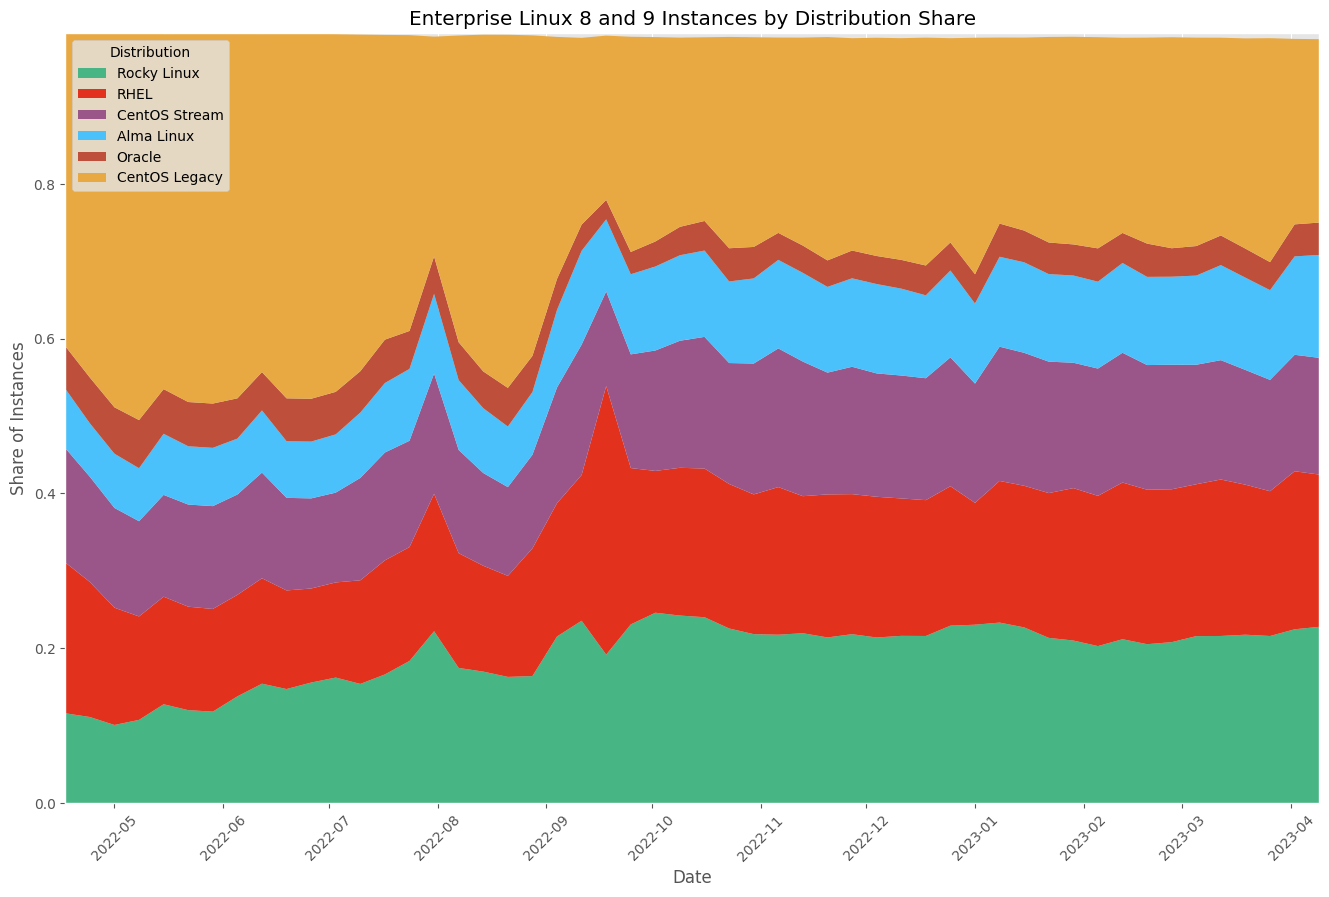

In [156]:
# Enterprise Linux Instances by Distribution Share
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['Rocky Linux']/pt['total'], pt['Red Hat Enterprise Linux']/pt['total'], pt['CentOS Stream']/pt['total'], pt['AlmaLinux']/pt['total'], pt['Oracle Linux Server']/pt['total'], pt['CentOS Linux']/pt['total'], \
             labels=['Rocky Linux', 'RHEL', 'CentOS Stream', 'Alma Linux', 'Oracle', 'CentOS Legacy'], \
             colors=['#48B585', '#E2321D', '#9A5689', '#4AC1FA', '#BE503B', '#E9A942'])
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))

plt.title('Enterprise Linux 8 and 9 Instances by Distribution Share')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share of Instances')
plt.legend(title='Distribution', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el89_by_distro_total_share_area.png', bbox_inches='tight')

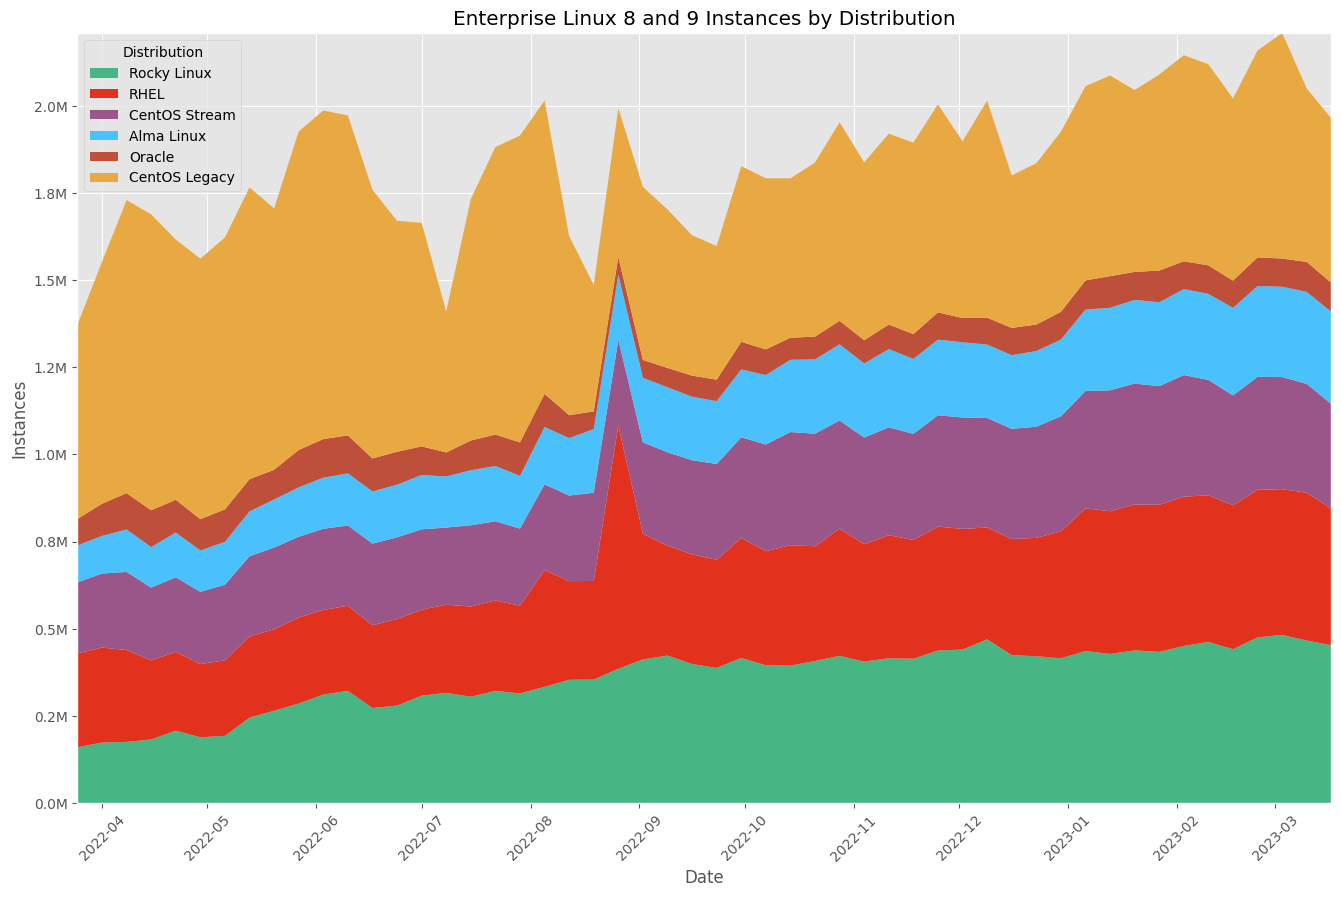

In [157]:
# Enterprise Linux Instances by Distribution 
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['Rocky Linux'], pt['Red Hat Enterprise Linux'], pt['CentOS Stream'], pt['AlmaLinux'], pt['Oracle Linux Server'], pt['CentOS Linux'], labels=['Rocky Linux', 'RHEL', 'CentOS Stream', 'Alma Linux', 'Oracle', 'CentOS Legacy'], colors=['#48B585', '#E2321D', '#9A5689', '#4AC1FA', '#BE503B', '#E9A942'])
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(millions))
plt.title('Enterprise Linux 8 and 9 Instances by Distribution')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el89_by_distro_total_area.png', bbox_inches='tight')

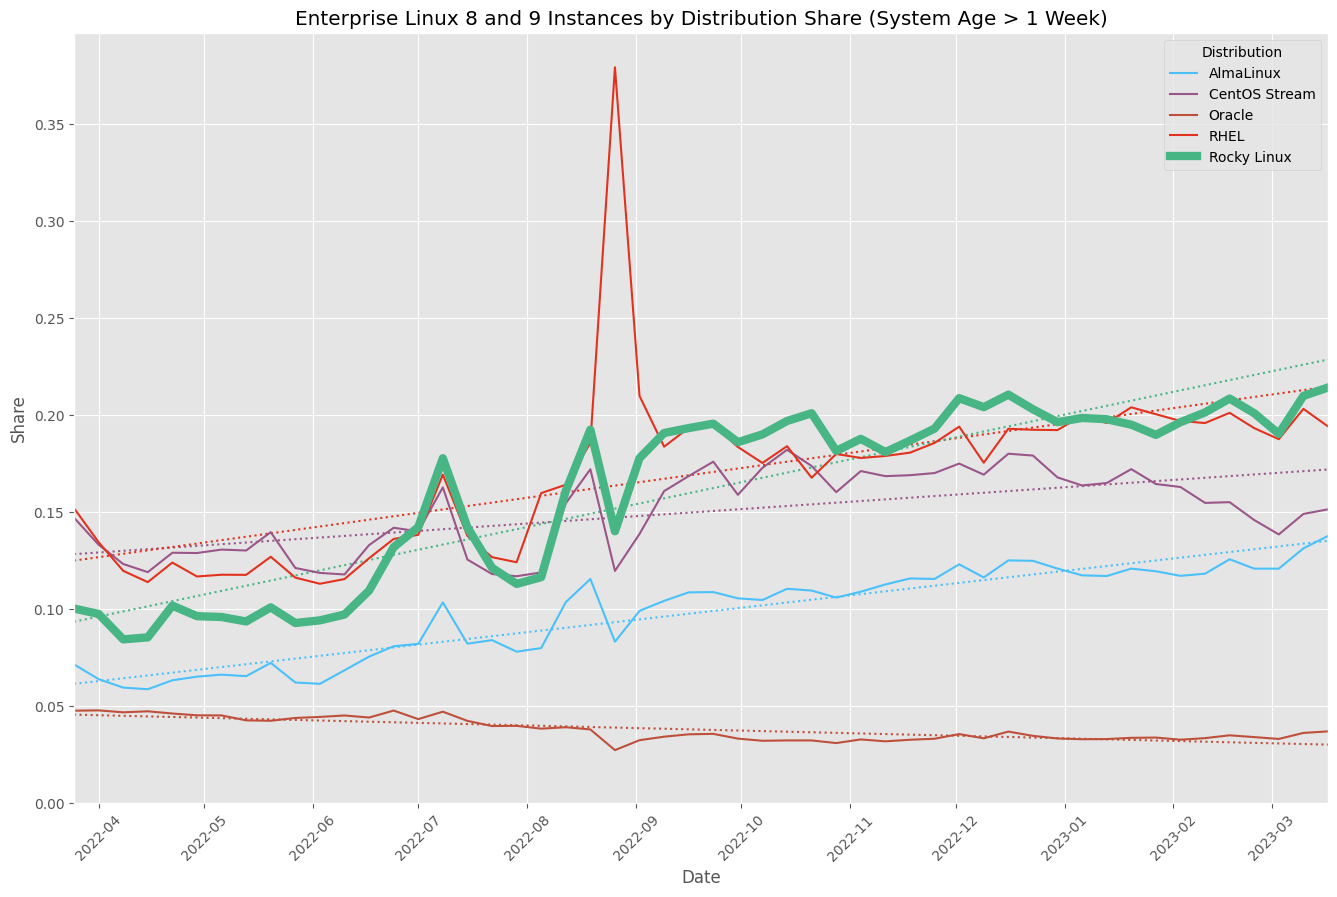

In [158]:
# Enterprise Linux Instances by Distribution Share
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro]/pt['total'], 1)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro]/pt['total'], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro]/pt['total'], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 and 9 Instances by Distribution Share (System Age > 1 Week)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_share_line.png', bbox_inches='tight')

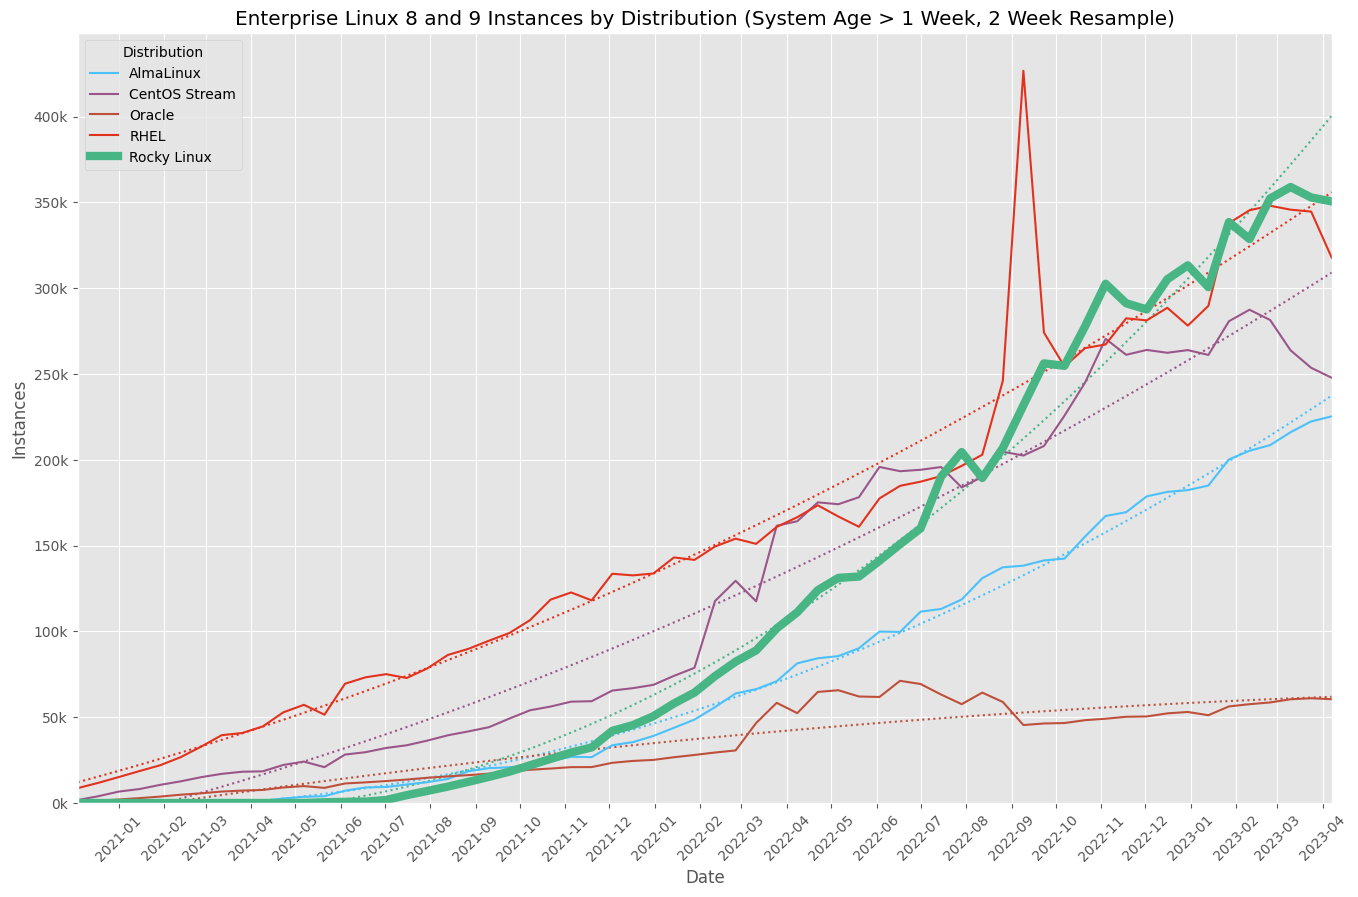

In [159]:
# Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] > 1) & (df['week_end'] > '2020-12-08')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

# TODO: Monthly averages?
pt = pt.resample('2W').mean()

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro], 2)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

# TODO: labels
#idx = np.round(np.linspace(0, len(pt.index) - 1, 12)).astype(int)
#for x,y in zip(pt.index,pt[emphasize]):
#    label = "{:}".format(y)
#    plt.annotate(label, # this is the text
#                 (x,y), # these are the coordinates to position the label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 ha='center') # horizontal alignment can be left, right or center

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 and 9 Instances by Distribution (System Age > 1 Week, 2 Week Resample)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_longterm_line.png', bbox_inches='tight')

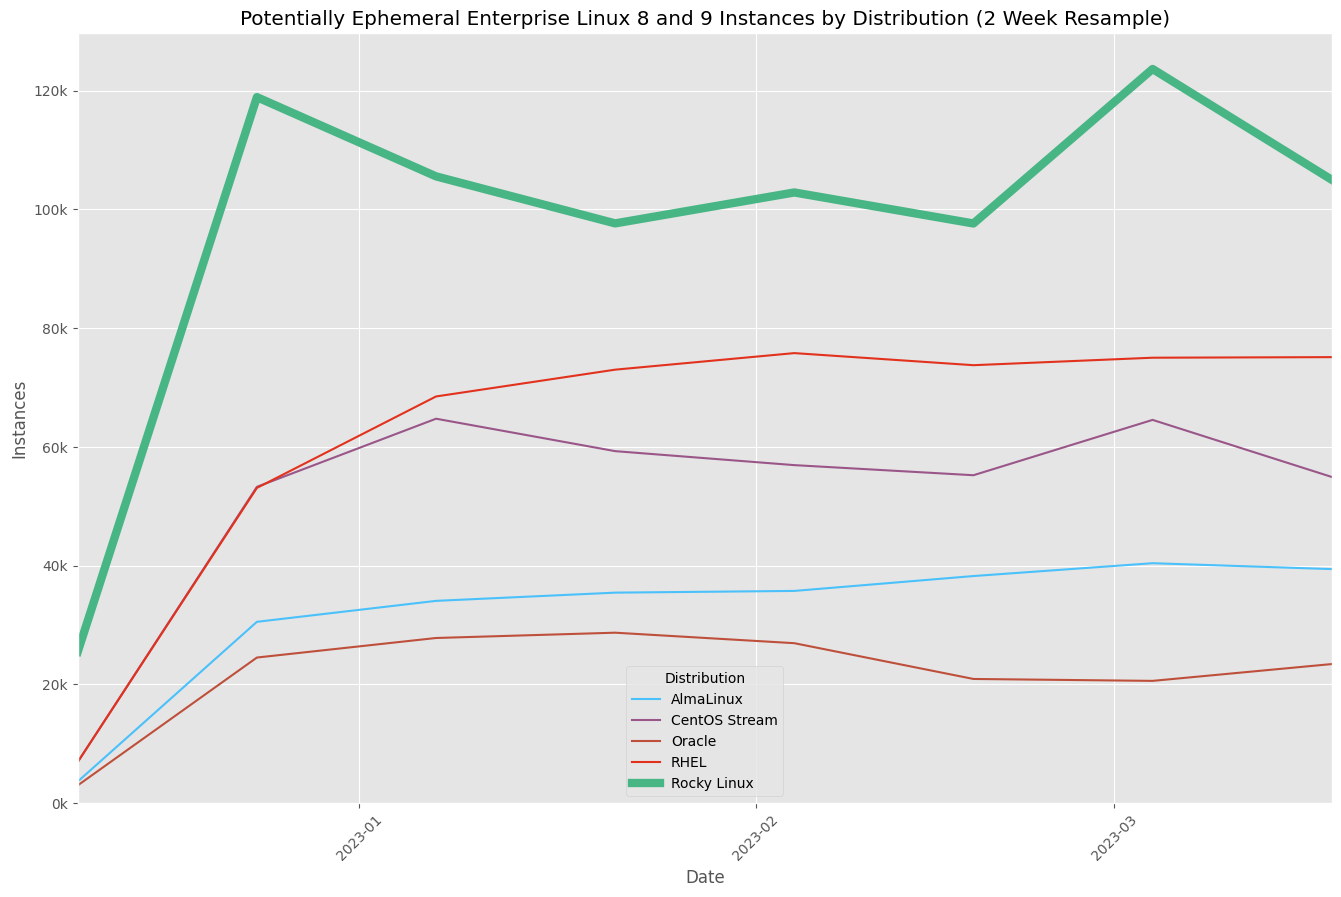

In [138]:
# Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] == 1) & (df['week_end'] > '2020-12-08')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

# TODO: Monthly averages?
pt = pt.resample('2W').mean()

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Potentially Ephemeral Enterprise Linux 8 and 9 Instances by Distribution (2 Week Resample)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_ephemeral_longterm_line.png', bbox_inches='tight')

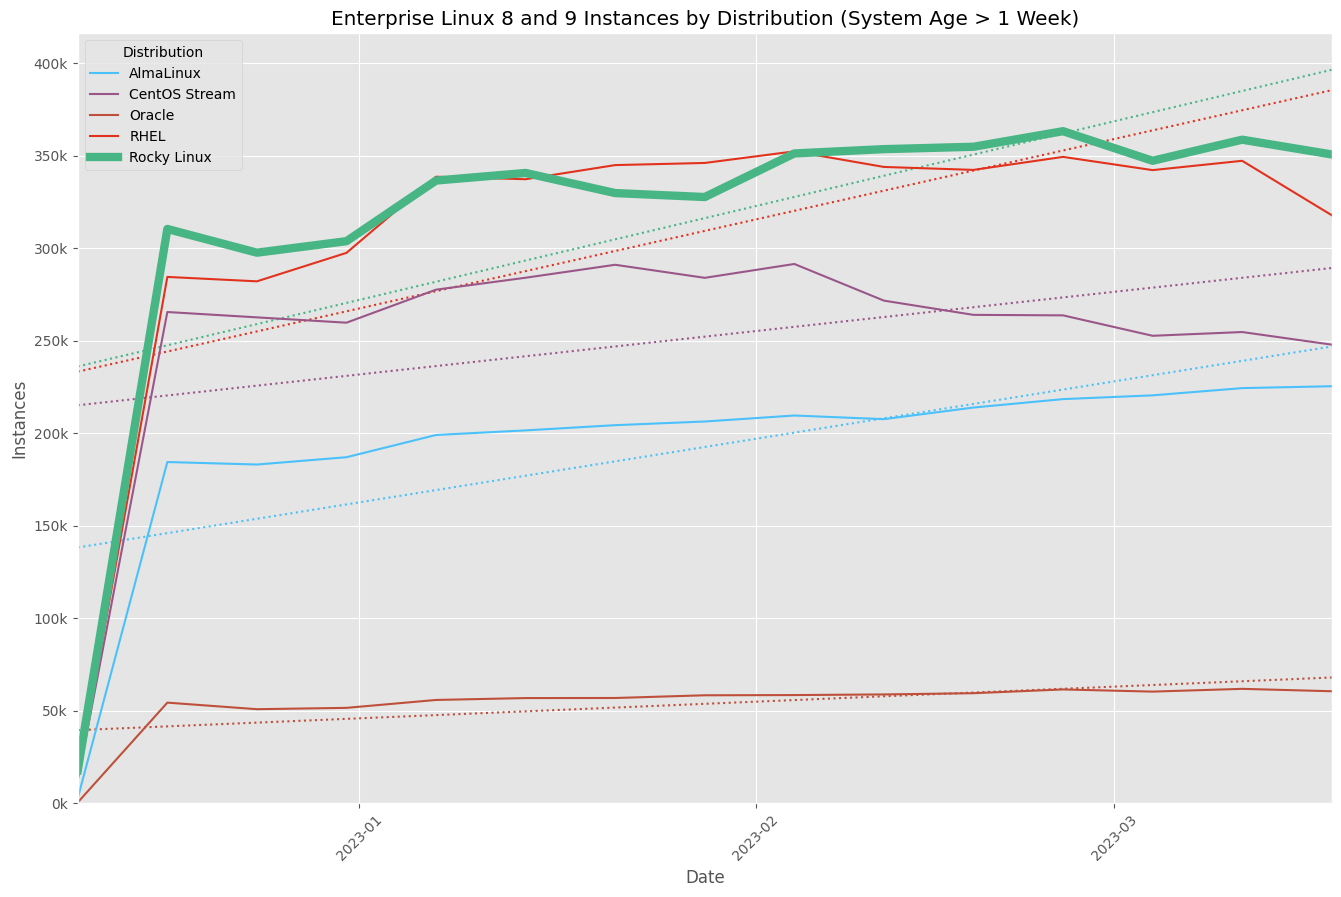

In [139]:
# Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

# TODO: Monthly averages?
# pt = pt.resample('M').mean()

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro], 1)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

# TODO: labels
#idx = np.round(np.linspace(0, len(pt.index) - 1, 12)).astype(int)
#for x,y in zip(pt.index,pt[emphasize]):
#    label = "{:}".format(y)
#    plt.annotate(label, # this is the text
#                 (x,y), # these are the coordinates to position the label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 ha='center') # horizontal alignment can be left, right or center

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 and 9 Instances by Distribution (System Age > 1 Week)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_line.png', bbox_inches='tight')

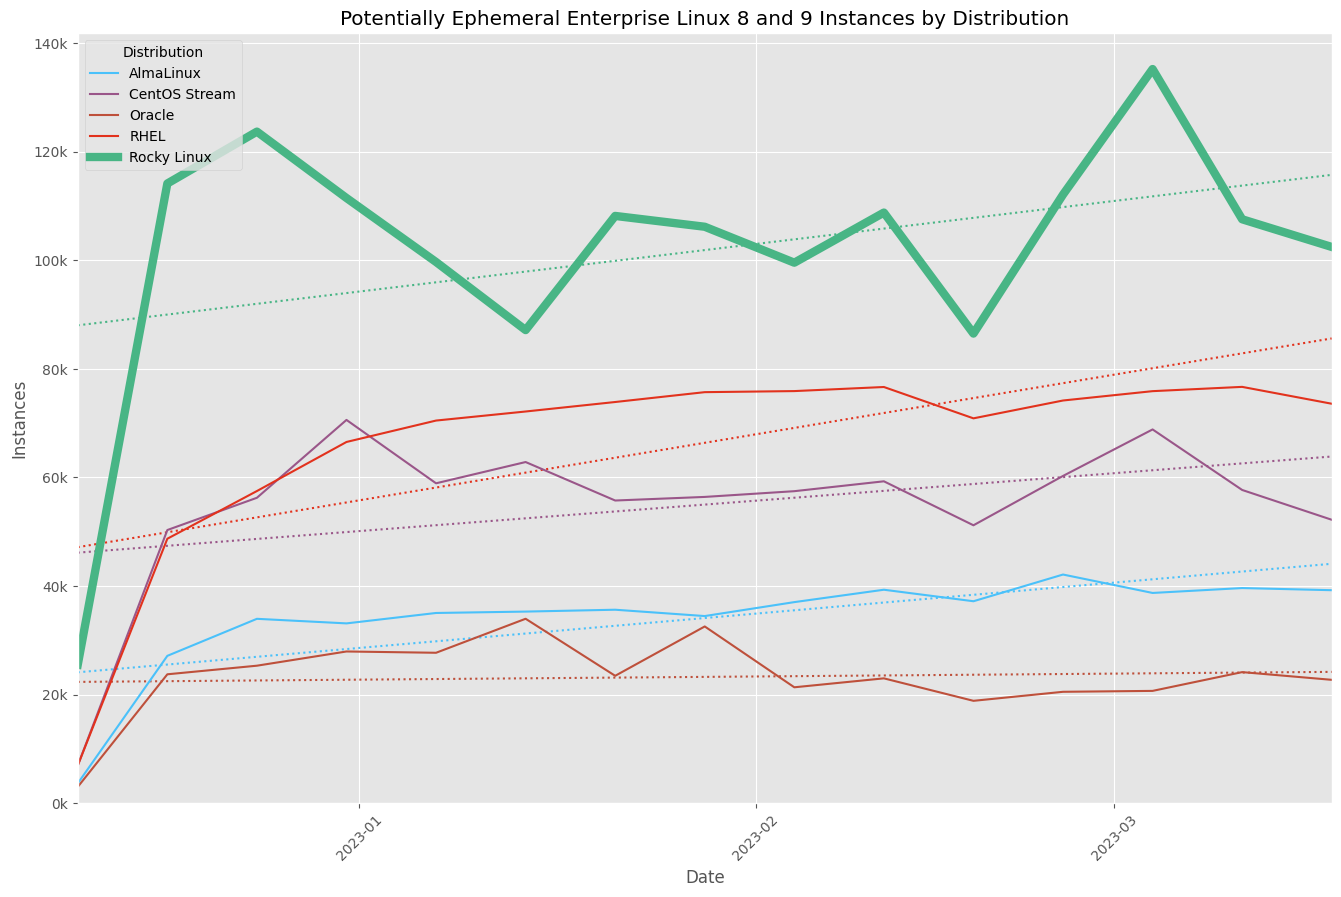

In [140]:
# Potentially Ephemeral Enterprise Linux Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['sys_age'] == 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  x = mdates.date2num(pt.index)
  z = np.polyfit(x, pt[distro], 1)
  p = np.poly1d(z)
  xx = np.linspace(x.min(), x.max(), 100)
  dd = mdates.num2date(xx)
  ax.plot(dd, p(xx), ':', color=colors[distro])
    
for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])
    
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Potentially Ephemeral Enterprise Linux 8 and 9 Instances by Distribution')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(loc='upper left', title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_distro_ephemeral_line.png', bbox_inches='tight')

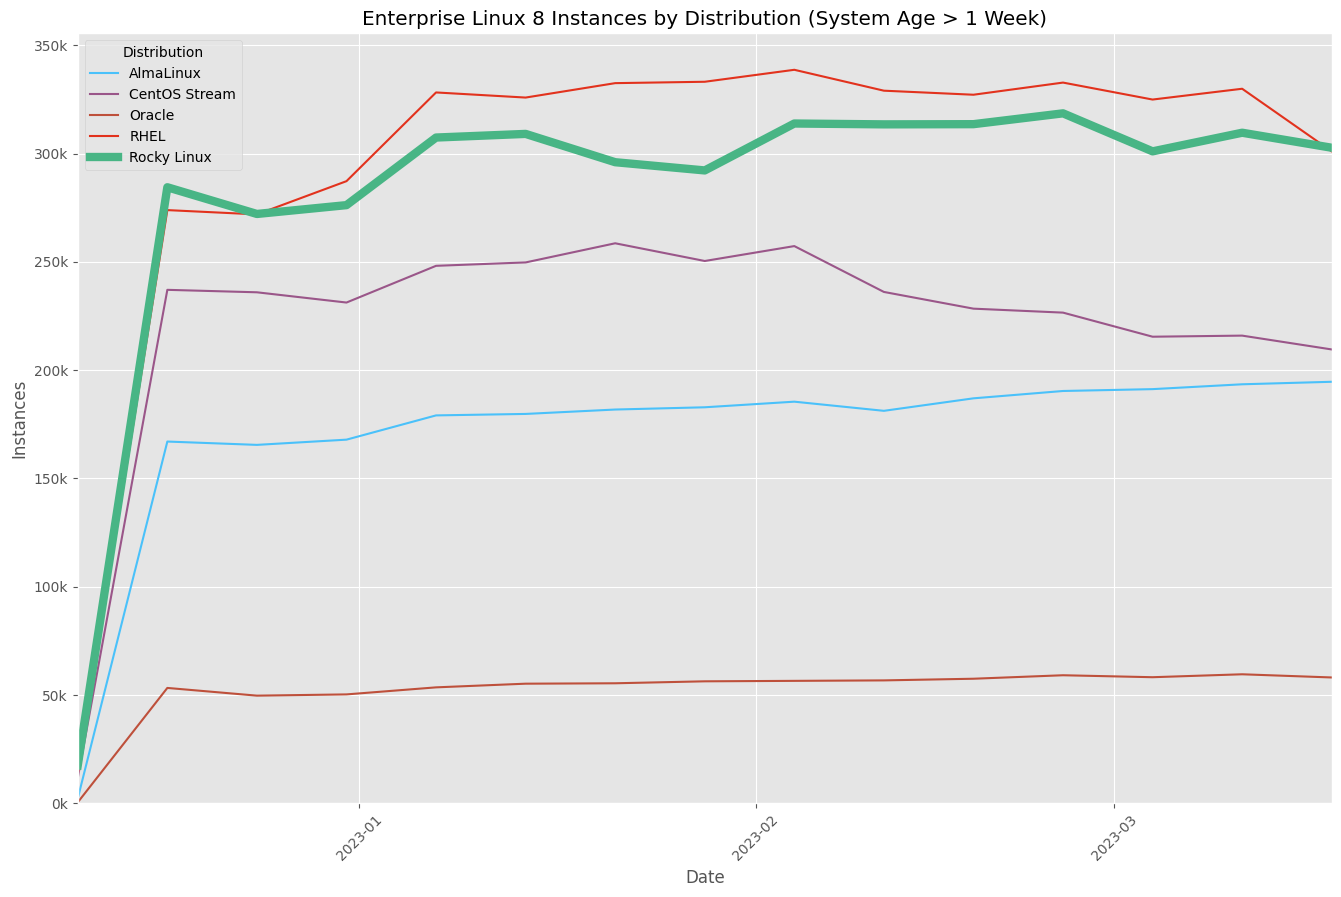

In [141]:
# Enterprise Linux 8 Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'] == 'epel-8') & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  if distro == 'Rocky Linux':
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 8 Instances by Distribution (System Age > 1 Week)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el8_by_distro_line.png', bbox_inches='tight')

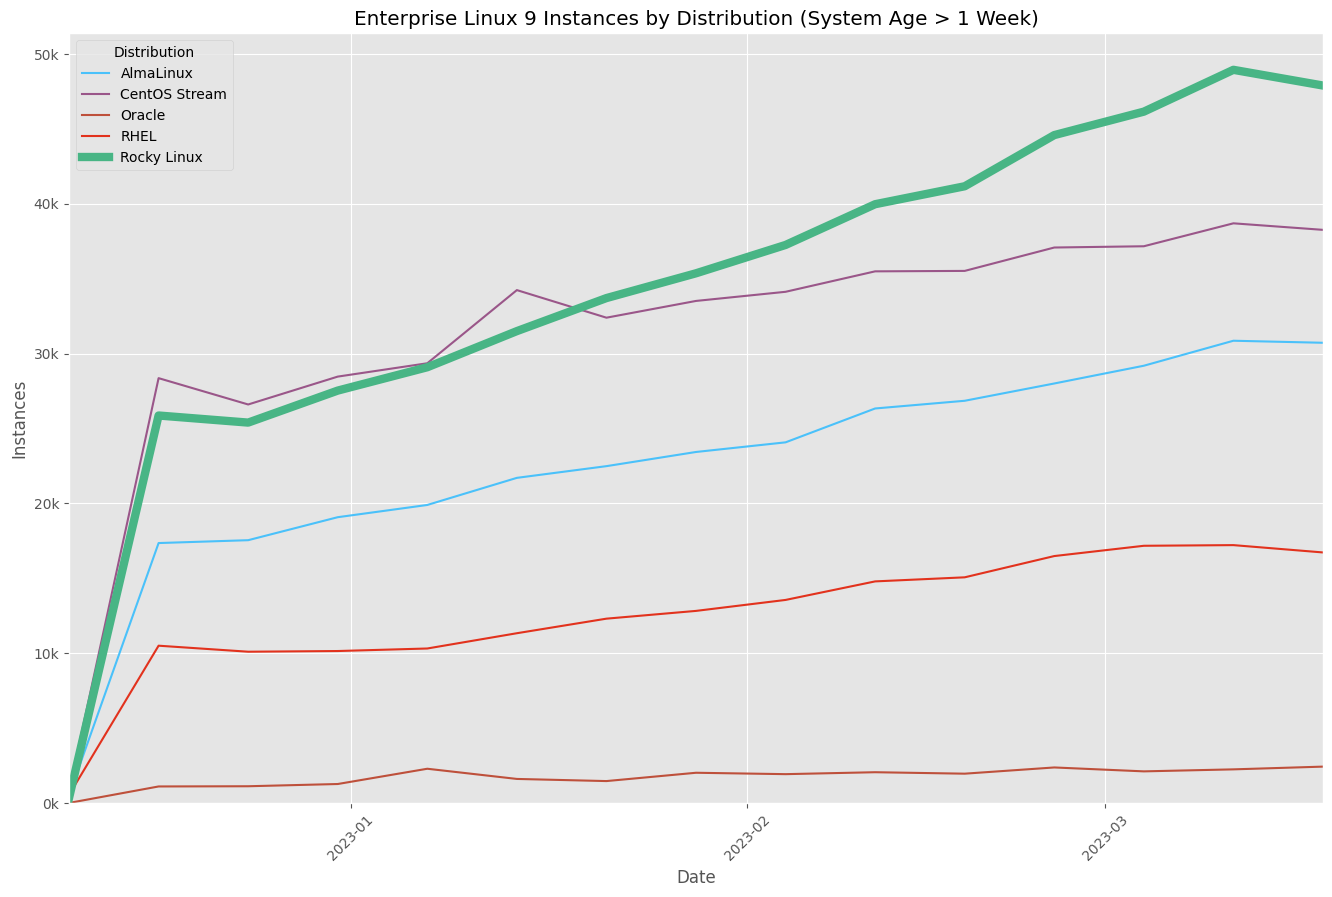

In [142]:
# Enterprise Linux 9 Instances by Distribution
df = epel_dataframe
df = df[(df['repo_tag'] == 'epel-9') & (df['sys_age'] > 1) & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_name', aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

for distro in distros:
  if distro == emphasize:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro], linewidth=6)
  else:
    ax.plot(pt[distro], label=labels[distro], color=colors[distro])

xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.set_ylim(bottom=0)
plt.title('Enterprise Linux 9 Instances by Distribution (System Age > 1 Week)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
plt.legend(title='Distribution')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el9_by_distro_line.png', bbox_inches='tight')

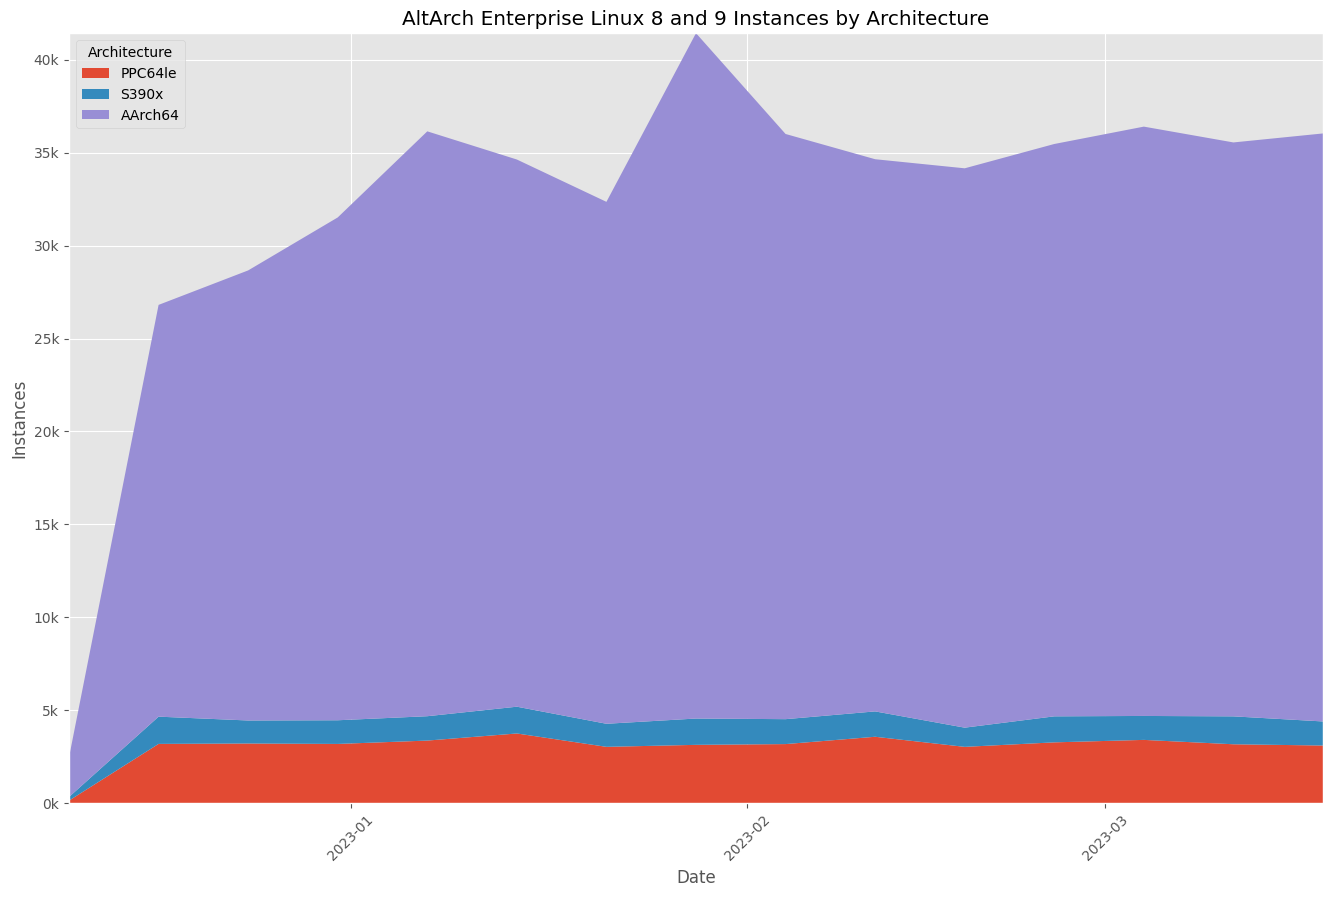

In [143]:
# AltArch Enterprise Linux Instances by Architecture
df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['repo_arch'] != 'x86_64')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='repo_arch', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['ppc64le'], pt['s390x'], pt['aarch64'], labels=['PPC64le', 'S390x', 'AArch64'])
xmajorrule = mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY))
ax.xaxis.set_major_locator(xmajorrule)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
plt.title('AltArch Enterprise Linux 8 and 9 Instances by Architecture')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Instances')
# plt.yticks(np.arange(0, 500001, step=50000))
plt.legend(title='Architecture', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'altarch_by_arch_area.png', bbox_inches='tight')

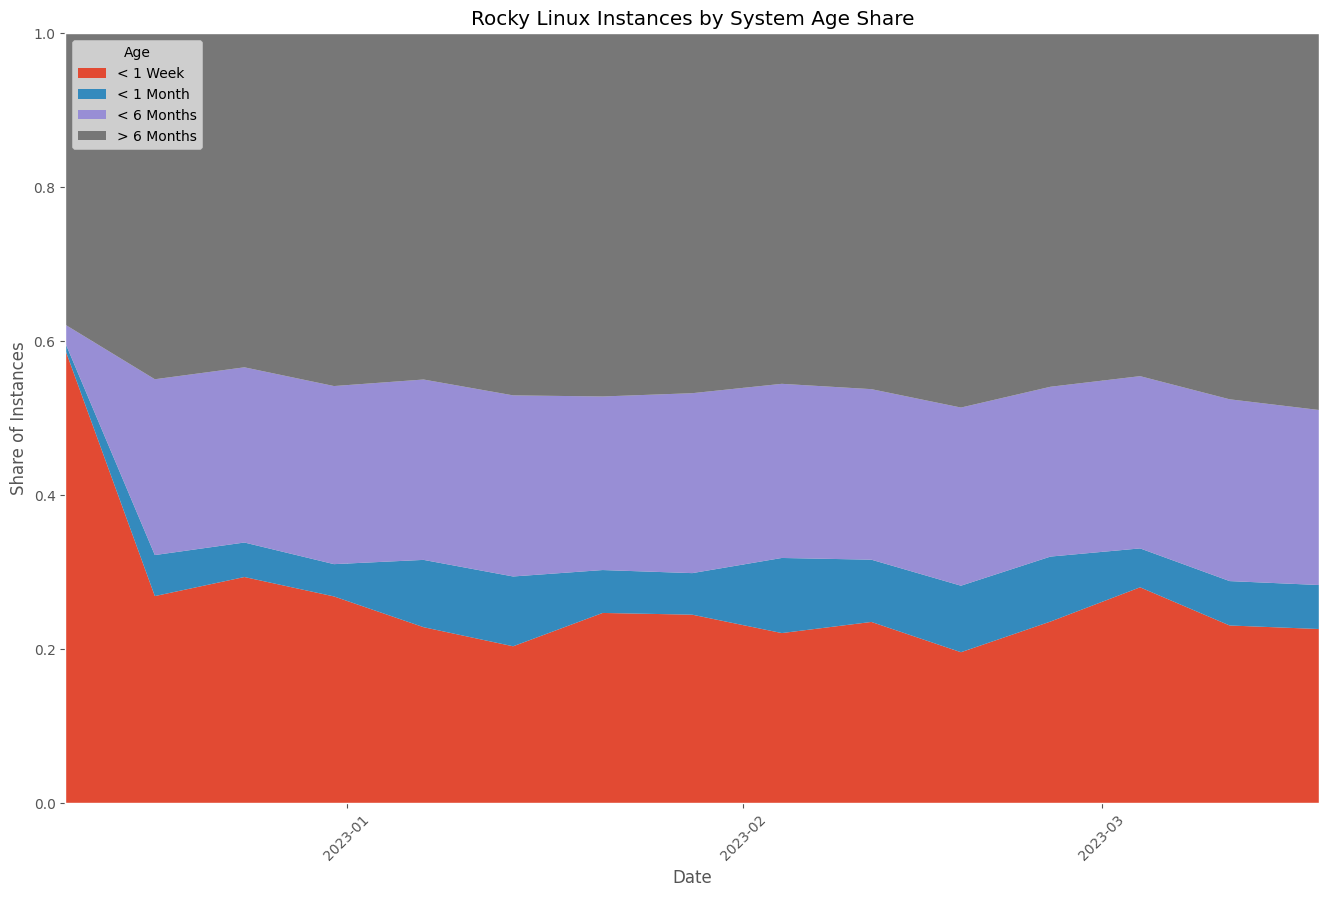

In [144]:
# Rocky Linux Instances by System Age Share

df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['week_end'] > startdate) & (df['os_name'] == 'Rocky Linux')]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='sys_age', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt[1]/pt['total'], pt[2]/pt['total'], pt[3]/pt['total'], pt[4]/pt['total'], labels=['< 1 Week', '< 1 Month', '< 6 Months', '> 6 Months'])

ax.xaxis.set_major_locator(mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY)))

plt.title('Rocky Linux Instances by System Age Share')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share of Instances')
# plt.yticks(np.arange(0, 500001, step=50000))
plt.legend(title='Age', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'rocky_by_age_share_area.png', bbox_inches='tight')

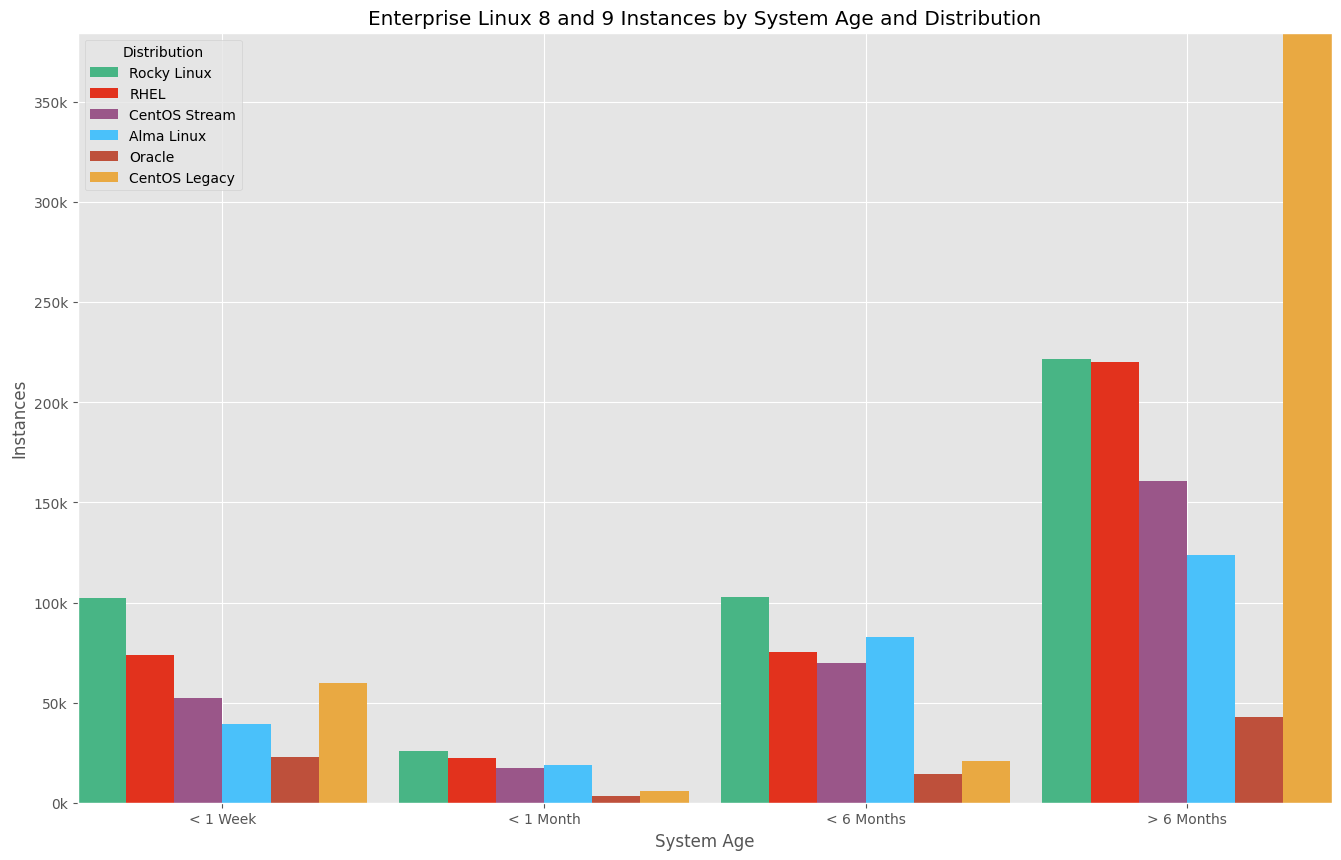

In [145]:
# Enterprise Linux Instances by System Age and Distribution

df = epel_dataframe
df = df[(df['week_end'] == df['week_end'][df.index[-1]]) & (df['repo_tag'].isin(['epel-8', 'epel-9']))]
pt = pd.pivot_table(df, values='hits', index='sys_age', columns='os_name', fill_value=0, aggfunc=np.sum)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()

labels = ['< 1 Week', '< 1 Month', '< 6 Months', '> 6 Months']
x = np.arange(len(pt.index))
width = 0.15

ax.bar(x - 5*(width/2), pt['Rocky Linux'], width, label='Rocky Linux', color='#48B585')
ax.bar(x - 3*(width/2), pt['Red Hat Enterprise Linux'], width, label='RHEL', color='#E2321D')
ax.bar(x - 1*(width/2), pt['CentOS Stream'], width, label='CentOS Stream', color='#9A5689')
ax.bar(x + 1*(width/2), pt['AlmaLinux'], width, label='Alma Linux', color='#4AC1FA')
ax.bar(x + 3*(width/2), pt['Oracle Linux Server'], width, label='Oracle', color='#BE503B')
ax.bar(x + 5*(width/2), pt['CentOS Linux'], width, label='CentOS Legacy', color='#E9A942')
ax.set_xticks(x, labels)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))

plt.title('Enterprise Linux 8 and 9 Instances by System Age and Distribution')
plt.xlabel('System Age')
plt.ylabel('Instances')
plt.legend(title='Distribution', loc='upper left')
plt.margins(0, tight=True)
plt.savefig(workdir + 'el_by_age_distro_bars.png', bbox_inches='tight')

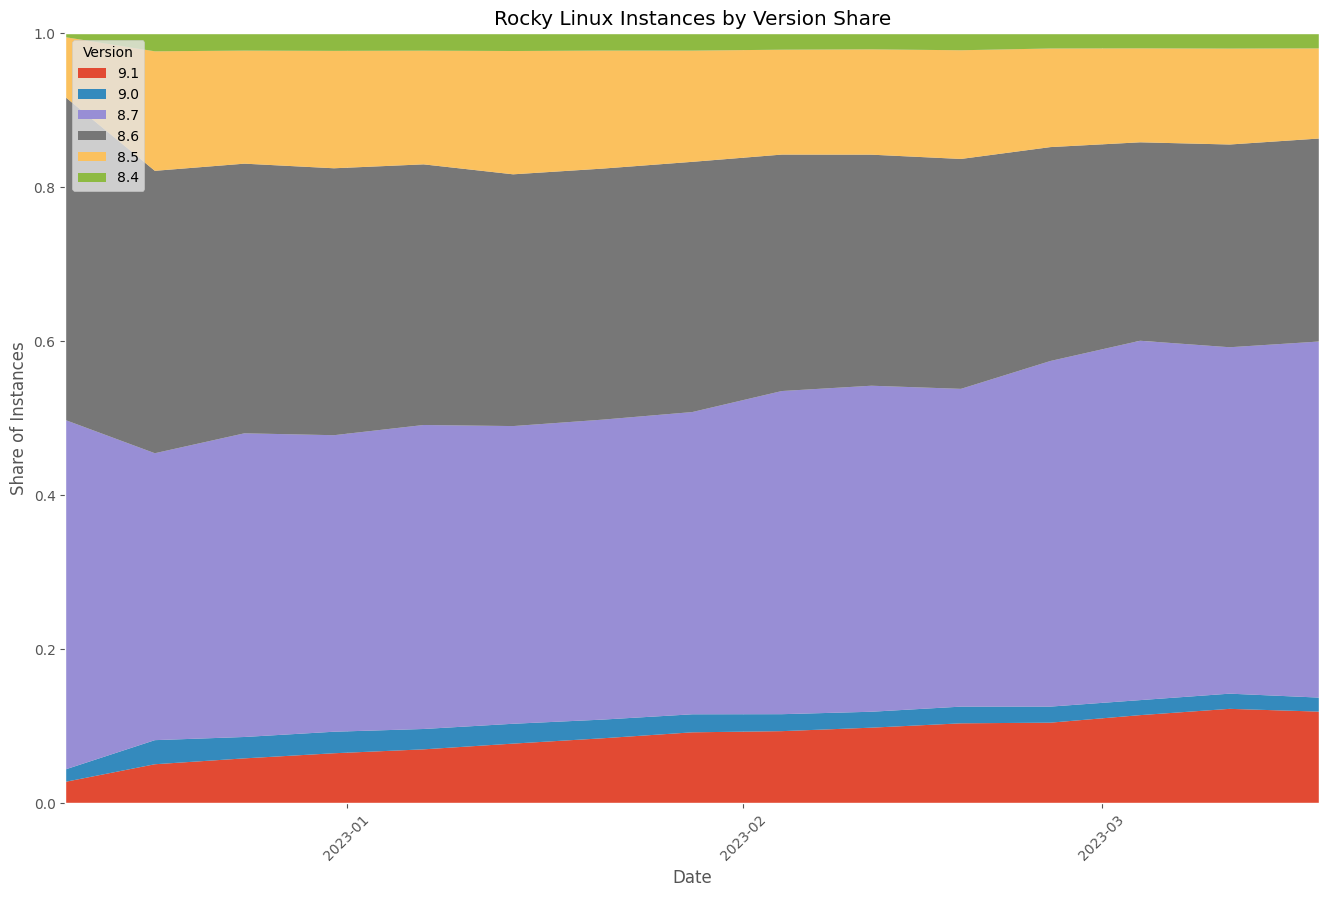

In [146]:
# Rocky Linux Instances by Version Share

df = epel_dataframe
df = df[(df['repo_tag'].isin(['epel-8', 'epel-9'])) & (df['os_name'] == 'Rocky Linux') & (df['week_end'] > startdate)]
pt = pd.pivot_table(df, values='hits', index='week_end', columns='os_version', fill_value=0, aggfunc=np.sum)

pt['total'] = pt.sum(numeric_only = True, axis = 1)

plt.style.use(plotstyle)
fig = plt.figure(figsize=(figx, figy))
ax = fig.add_subplot()
ax.stackplot(pt.index, pt['9.1']/pt['total'], pt['9.0']/pt['total'], pt['8.7']/pt['total'], pt['8.6']/pt['total'], pt['8.5']/pt['total'], pt['8.4']/pt['total'], \
             labels=['9.1', '9.0', '8.7', '8.6', '8.5', '8.4'])

ax.xaxis.set_major_locator(mdates.RRuleLocator(mdates.rrulewrapper(mdates.MONTHLY)))

plt.title('Rocky Linux Instances by Version Share')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Share of Instances')
plt.legend(loc='upper left', title='Version')
plt.margins(0, tight=True)
plt.savefig(workdir + 'rocky_by_version_share_area.png', bbox_inches='tight')